In [1]:
from sklearn.cluster import KMeans
from matplotlib.image import imread
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from yellowbrick.cluster import KElbowVisualizer
import numpy as np
import os
import cv2

In [2]:
image = cv2.imread('input.png')

In [3]:
image.shape

(200, 200, 3)

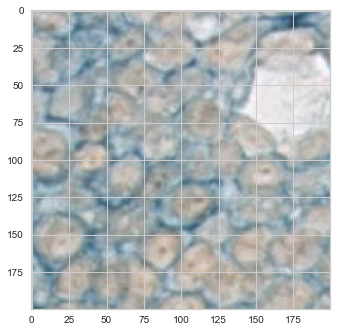

In [4]:
plt.imshow(image)

In [5]:
print('pixels: {}'.format(200*200))

pixels: 40000


In [6]:
X = image.reshape(-1,3)

In [7]:
print(X.shape)

(40000, 3)


In [8]:
kmeans = KMeans(n_clusters=2, random_state=100).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]

In [9]:
segmented_img.shape

(40000, 3)

(200, 200, 3)


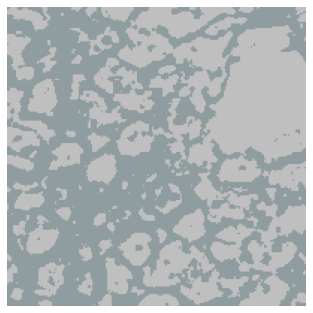

In [10]:
segmented_img = segmented_img.reshape(image.shape)
print(segmented_img.shape)
plt.figure()
plt.imshow(segmented_img.astype('uint8'))
plt.axis("off")
plt.show()

In [11]:
segmented_imgs = []
n_colors = (16,14,12,10,8,6,4,2,1)

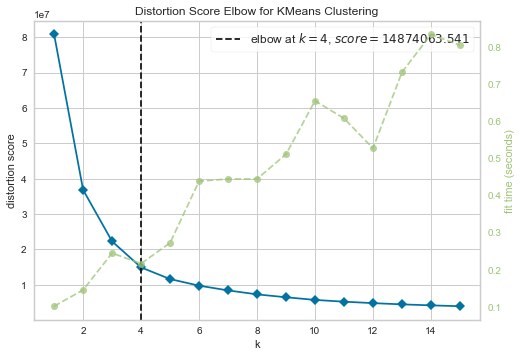

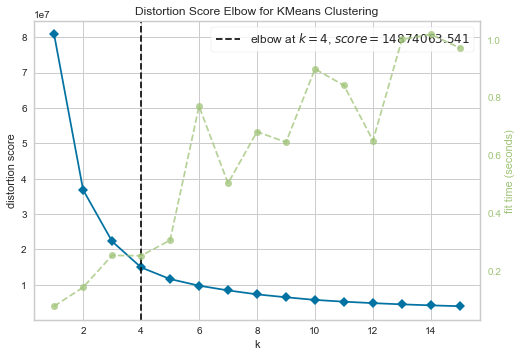

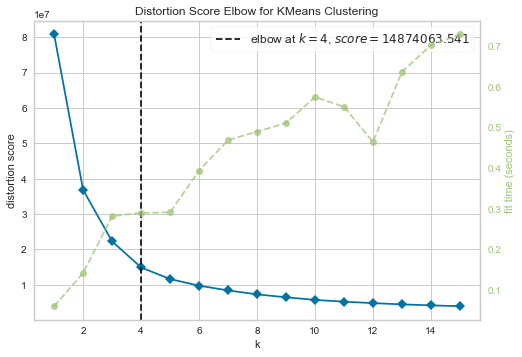

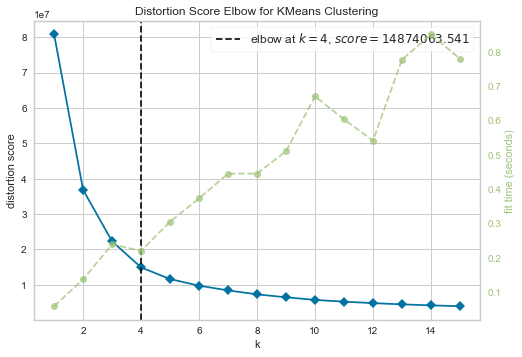

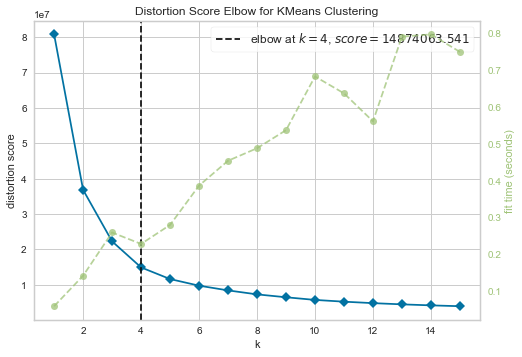

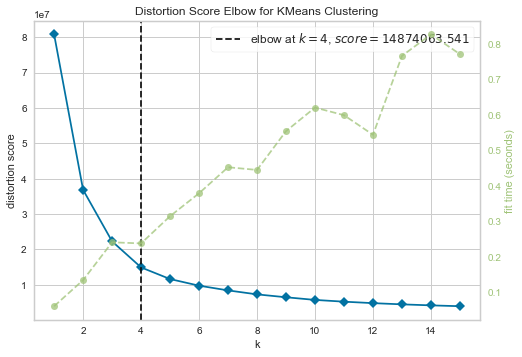

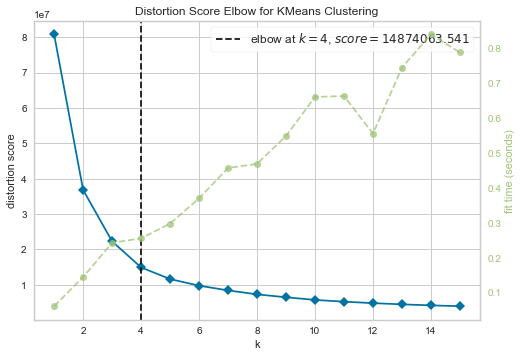

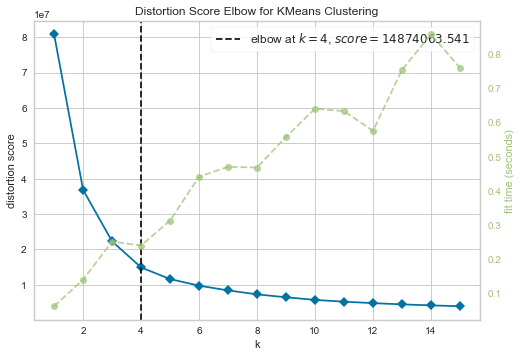

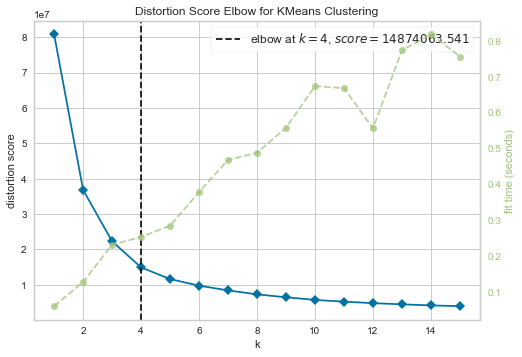

In [12]:
#probar con n_colors cantidad de clsters
distortions = []
inertias = {}
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=232).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))
    distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias[n_clusters] = kmeans.inertia_
    visualizer = KElbowVisualizer(kmeans, k=(1,16))
    visualizer.fit(X)        # Fit the data to the visualizer
    visualizer.show() 

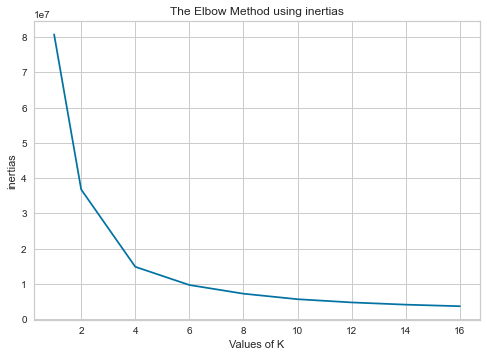

In [13]:
#gráfica de inercias, suma de las distancias de las muestras a su centro de cluster más cercano
#Por la heurística, se determina que el K óptimo es K=4
plt.plot(list(inertias.keys()), list(inertias.values()))
plt.xlabel('Values of K')
plt.ylabel('inertias')
plt.title('The Elbow Method using inertias')
plt.show()

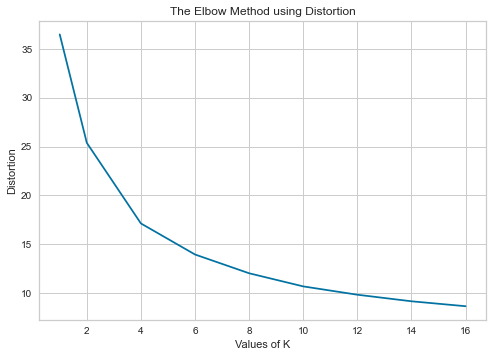

In [14]:
#gráfica de distorciones, se calcula como el promedio de las distancias al cuadrado desde los centros de sus 
#respectivos clusters. Distancia euclidiana
plt.plot(n_colors, distortions)
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

(16, 14, 12, 10, 8, 6, 4, 2, 1)
(200, 200, 3)


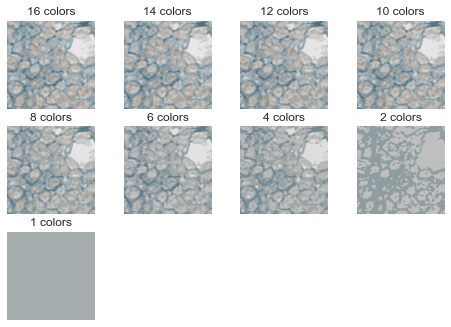

In [15]:
#plotear segmented_imgs y almacenar el k=4, ya que según codo, es el cluster óptimo 
print(n_colors)
best_cluster = None
K_clusters = 0
for idx, n_clusters in enumerate(n_colors):
    if n_clusters == 4:
        best_cluster,  K_clusters = segmented_imgs[idx].astype('uint8'), n_clusters
    plt.subplot(341+idx)
    plt.imshow(segmented_imgs[idx].astype('uint8'))
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')
two_colors = segmented_imgs[7]
print(best_cluster.shape)

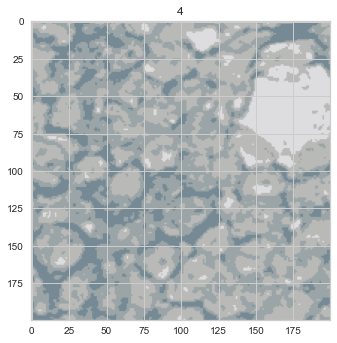

In [16]:
#Plotear el K = 4
plt.title(K_clusters)
plt.imshow(best_cluster)

(200, 200, 3)
(200, 200, 3)


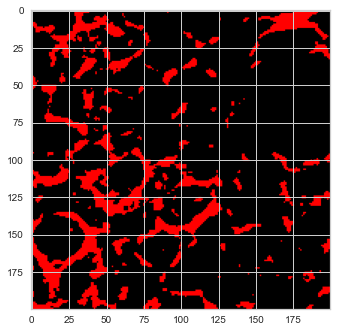

In [17]:
#Binarizar el K=4
ret, img_binary = cv2.threshold(best_cluster,127,255,cv2.THRESH_BINARY_INV)
expected_output = cv2.imread('out.png')
plt.imshow(img_binary)
print(img_binary.shape)
print(expected_output.shape)

In [18]:
#Cálculo de similarity usando norm, 
h, w, _ = img_binary.shape
errorL2 = cv2.norm(expected_output, img_binary, cv2.NORM_L2)
similarity = 1 - errorL2 / (h*w)
print("Similarity between k = {} and golden standard = {} ".format(K_clusters,similarity))

Similarity between k = 4 and golden standard = 0.45356915179045754 


In [19]:
#Cálculo de similarity de la imagen de input binarizada
ret, input_binary = cv2.threshold(image,127,255,cv2.THRESH_BINARY_INV)
print(input_binary.shape)
print(expected_output.shape)
errorL3 = cv2.norm(expected_output, input_binary, cv2.NORM_L2)
similarity = 1 - errorL3 / (h*w)
print("Similarity between original and golden standard = {} ".format(similarity))

(200, 200, 3)
(200, 200, 3)
Similarity between original and golden standard = 0.5320124701180596 


Respondiendo a las preguntas:
- Utilice el algorimto K-means para segmentar la imagen, y así identifica la sobre-expresión de la proteína HER2
Done
- ¿Cómo podría medir que tan bien se comporta el algoritmo con respecto al gold standard?
Se utiliza una comparación utilizando norm, para determinar la similaridad entre 2 imágenes. https://docs.opencv.org/3.4/d2/de8/group__core__array.html#:~:text=and%20CV_8UC1%20type.-,%E2%97%86%C2%A0,norm(),-%5B2/3%5D

- ¿Es apropiado el algortmo K-menas para esta tarea?
Se encuentra que para el número de clústers óptimo K=4 binarisado, hay una similaridad de 45% respecto al gold standard. De forma contraria, la imagen de input en binario posee una similaridad de 53% al gold standard, con lo cual para este caso particular, el algoritmo k-means no parece ser el apropiado